Nonlinear Least Squares
====

## Unit 12, Lecture 2

*Numerical Methods and Statistics*

----

#### Prof. Andrew White, April 17 2018

Goals:
---

1. Be able to apply the same analysis from 1D/ND OLS to NLS
2. Compute the F-matrix and understand its use in error analysis
3. Distinguish between when linearized OLS is possible and NLS is required

In [1]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.linalg as linalg
import matplotlib

Linearizing An Exponential
---

We previously learned how to linearize polynomials into OLS-ND. What about a more complex equation, like:

$$y = \beta_0 e^{-\beta_1 x^2} + \epsilon $$

Well, you could of course just do this:

$$\ln y = \ln\beta_0 - \beta_1 x^2 + \epsilon $$

and then choose our $x$ matrix to be $[1,-x^2]$

What is wrong with this?

**We changed our assumption of noise!** To do the math I just above, it should have been that our original equation was:
$$y = \beta_0 e^{-\beta_1 x^2}\times e^{\epsilon} $$ so that after taking the log, we ended up with that above. But that equation doesn't our assumption that we have normally distributed 0-centered noise.

Can we neglect our assumption of linear normal noise?
===

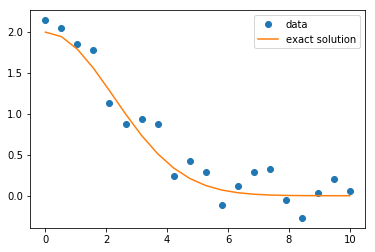

In [2]:
#NOT PART OF REGRESSION!
#Make up an equation and create data from it
x = np.linspace(0, 10, 20)
y = 2 * np.exp(-x**2 * 0.1) + scipy.stats.norm.rvs(size=len(x), loc=0, scale=0.2)
#END

plt.plot(x,y, 'o', label='data')
plt.plot(x, 2 * np.exp(-x**2 * 0.1), '-', label='exact solution')
plt.legend(loc='upper right')
plt.show()

In [3]:
#Now we compute the least squares solution

x_mat = np.column_stack( (np.ones(len(x)), -x**2) )

#Any negative y-values will not work, since log of a negative number is undefined
y_clean = []
for yi in y:
    if yi < 0:
        y_clean.append(0.0000001)
    else:
        y_clean.append(yi)

lin_y = np.log(y_clean)

#recall that the *_ means put all the other
#return values into the _ variable, which we 
#don't need
lin_beta, *_ = linalg.lstsq(x_mat, lin_y)
print(lin_beta)
beta_0 = np.exp(lin_beta[0])
beta_1 = lin_beta[1]

print(beta_0, 2)
print(beta_1, 0.1)

[-0.39211931  0.07860197]
0.6756235005402879 2
0.07860197052427415 0.1


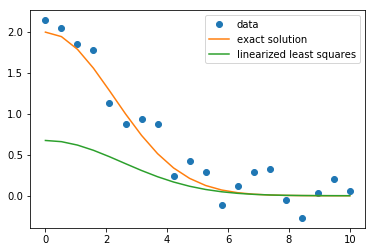

In [4]:
plt.plot(x,y, 'o', label='data')
plt.plot(x, 2 * np.exp(-x**2 * 0.1), '-', label='exact solution')
plt.plot(x, beta_0 * np.exp(-x**2 * beta_1), '-', label='linearized least squares')
plt.legend(loc='upper right')
plt.show()

**NO, we cannot linearize and ignore the impact on noise**

Checking if Linearization is Valid
====

The way to check if the linearization is valid is to see if the residuals are normally distributed. Since you are assuming the noise is normal after linearization, you can check that assumption:

In [5]:
resids = y - beta_0 * np.exp(-x**2 * beta_1)
scipy.stats.shapiro(resids)

(0.8977533578872681, 0.03743453323841095)

The Shapiro-Wilk test says absolutely not are they normal, as we can imagine from looking at the graph.

Nonlinear Multidimensional Least-Squares
====

To treat things like the exponential distribution from above, we need to use an objective function and minimization. We'll minimize the SSR directly:

$$SSR = \sum_i (\hat{y}_i - y_i)^2 $$

$$SSR = \sum_i (\beta_0 e^{-\beta_1 x^2} - y_i)^2 $$

So our SSR is a function which takes in $(\beta_0, \beta_1)$

We're going to use a new technique this time. Instead of relying on the data being defined, we'll have our SSR take that as extra arguments and we'll tell the minimizer about these extra args.

In [6]:
#Create an objective function, that takes in 1 D-dimensional argument and outputs a measure of the goodness of fit (SSR)
def obj(beta, x, y):
    beta_0 = beta[0] #<- extract the elements of the beta vector
    beta_1 = beta[1]
    yhat = beta_0 * np.exp(-beta_1 * x**2) # <- This is our model equation
    resids = yhat - y #<- compute residuals
    SSR = np.sum(resids**2) #<- square and sum them
    return SSR

#Use the minimize (BGFS) function, with starting points
result = scipy.optimize.minimize(obj, x0=[1,1], args=(x, y))
beta_opt = result.x #<- remember, we get out a whole bunch of extra stuff from optimization
print(result)

      fun: 0.6387351593324605
 hess_inv: array([[0.16566385, 0.01037387],
       [0.01037387, 0.00203523]])
      jac: array([ 5.21540642e-08, -4.61935997e-07])
  message: 'Optimization terminated successfully.'
     nfev: 80
      nit: 12
     njev: 20
   status: 0
  success: True
        x: array([2.06618151, 0.08906969])


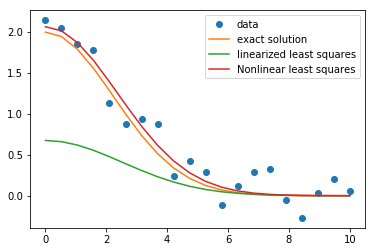

In [7]:
plt.plot(x,y, 'o', label='data')
plt.plot(x, 2 * np.exp(-x**2 * 0.1), '-', label='exact solution')
plt.plot(x, beta_0 * np.exp(-x**2 * beta_1), '-', label='linearized least squares')
plt.plot(x, beta_opt[0] * np.exp(-x**2 * beta_opt[1]), '-', label='Nonlinear least squares')
plt.legend(loc='upper right')
plt.show()

Error Analysis in Nonlinear Least Squares
====

Just like for the one-dimensional and multidimensional case, there exists an expression to go from standard error in the residuals to standard error for the fit. That expression is:

$$y = f(\beta, x) + \epsilon$$

$$ F_{ij} = \frac{\partial f(\hat{\beta}, x_i)}{\partial \hat{\beta_j}}$$

$$S^2_{\beta_{ij}} = S^2_{\epsilon}\left(\mathbf{F}^T\mathbf{F}\right)^{-1}$$

where again, the standard error for the $i$th given fit parameter is $S^2_{\beta{ii}}$

Take a close look at the partial derivatives. $x_i$ can be a vector here and remember that you're taking the partial with respect to the fit parameters, not $x$

Sketch of Derivation of Error Terms
====

Let's try to understand this equation. It is a generalization of the OLS in N-D, so our derivation will apply to all cases we learned in lecture 1 too.

Consider the $\mathbf{F}^T\mathbf{F}$ term. You can see by expanding the terms that it is

$$
\mathbf{F}^T\mathbf{F} = \sum_k^N \frac{\partial f(\hat{\beta}, x_k)}{\partial \hat{\beta_i}} \frac{\partial f(\hat{\beta}, x_k)}{\partial \hat{\beta_j}}
$$

where $i$ is the row and $j$ is the index. This expression is approximately:

$$
\mathbf{F}^T\mathbf{F} \approx \frac{\sum_k^N 
\left(\Delta f(\hat{\beta}, x_k)\right)^2}{\Delta\hat{\beta_i} \Delta \hat{\beta_j}}
$$

So the *diagonal* of $\mathbf{F}^T\mathbf{F}$ is the total change in the value of the squared function per change in the square of the value of a fit coefficient.

$$
\mathrm{diag}\left[\mathbf{F}^T\mathbf{F}\right] \approx \frac{\sum_k^N 
\left(\Delta f(\hat{\beta}, x_k)\right)^2}{\Delta\hat{\beta_i}^2}
$$

We can loosely think of $\mathbf{F}^T\mathbf{F}$ as a function, or operator, that goes from a change in the fit coefficients squared to a change in the squared value of the function. 

We also know that our residual, $f(\hat{\beta}, x) - y$, has the same derivative wrt the fit coefficients as the function itself. Thus $\mathbf{F}^T\mathbf{F}$ allows us to compute a change in the residual given a change in the fit coefficients (*this is a simplification*).

Therefore the inverse, $\left(\mathbf{F}^T\mathbf{F}\right)^{-1}$, goes from a change in the residual squared to a change in the fit coefficients squared.

Now we can see that:
    
$$ S^2_{\epsilon}\left(\mathbf{F}^T\mathbf{F}\right)^{-1} $$

is the product of a change in the residual squared with our operator that translate that into a squared change in the fit coefficient squared. 

Example: Error Analysis for Exponential Fit in Nonlinear Least Squares
----

To do the analysis from our example above, we must first compute the partial derivatives. Recall the model is:

$$y = \beta_0 e^{-\beta_1 x^2} + \epsilon $$

So that 

$$f(\beta, x) = \beta_0 e^{-\beta_1 x^2}$$

$$\frac{\partial f}{\partial \beta_0} = e^{-\beta_1 x^2}$$
$$\frac{\partial f}{\partial \beta_1} = -\beta_0 x^2 e^{-\beta_1 x^2}$$

To compute $\mathbf{F}$, we'll need to compute these functions at various points, so it's best to create a python function

In [8]:
def build_F(beta, x):
    #Compute the individual partials for each data point
    beta_0_vec = np.exp(-beta[1] * x**2)
    beta_1_vec = -beta[0] * x**2 * np.exp(-beta[1] * x**2)
    #Now stack them together
    return np.column_stack( (beta_0_vec, beta_1_vec) )

print(build_F(beta_opt, x))

[[ 1.00000000e+00 -0.00000000e+00]
 [ 9.75628846e-01 -5.58400633e-01]
 [ 9.06021555e-01 -2.07424375e+00]
 [ 8.00869385e-01 -4.12539436e+00]
 [ 6.73835860e-01 -6.17071333e+00]
 [ 5.39654511e-01 -7.72177405e+00]
 [ 4.11383405e-01 -8.47638235e+00]
 [ 2.98501825e-01 -8.37152039e+00]
 [ 2.06165730e-01 -7.55192591e+00]
 [ 1.35536176e-01 -6.28349852e+00]
 [ 8.48131602e-02 -4.85427655e+00]
 [ 5.05173461e-02 -3.49854260e+00]
 [ 2.86409272e-02 -2.36053712e+00]
 [ 1.54562056e-02 -1.49503327e+00]
 [ 7.93940509e-03 -8.90646369e-01]
 [ 3.88188176e-03 -4.99903399e-01]
 [ 1.80661623e-03 -2.64708047e-01]
 [ 8.00310988e-04 -1.32378633e-01]
 [ 3.37458923e-04 -6.25787948e-02]
 [ 1.35441675e-04 -2.79847085e-02]]


Now to actually compute the standard error:

In [9]:
#The code below is our normal way of computing the standard error in the noise
resids = y - beta_opt[0] * np.exp(-x**2 * beta_opt[1])
SSR = np.sum(resids**2)
s2_epsilon = SSR / (len(x) - len(beta_opt))
print(s2_epsilon)

0.03548528662958114


In [10]:
#Using our F, compute the standard error in beta
F = build_F(beta_opt, x)

s2_beta = s2_epsilon * linalg.inv(F.transpose() @ F)
print(s2_beta)

[[0.01123071 0.00064552]
 [0.00064552 0.00012526]]


In [11]:
#We have standard error and can now compute a confidence interval
T = scipy.stats.t.ppf(0.975, len(x) - len(beta_opt))
c0_width = T * np.sqrt(s2_beta[0,0])
print('95% confidence interval for beta_0 is {:.3} +/ {:.2f}'.format(beta_opt[0], c0_width))

c1_width = T * np.sqrt(s2_beta[1,1])
print('95% confidence interval for beta_1 is {:.3} +/ {:.2}'.format(beta_opt[1], c1_width))

95% confidence interval for beta_0 is 2.07 +/ 0.22
95% confidence interval for beta_1 is 0.0891 +/ 0.024


Of course, we could continue on and do hypothesis tests

Multidimesional Non-Linear Regression
====

**These notes are not on HW or tests. Just stating how to do multidimensional y regression**

When we have multiple dimensions in $y$, the dependent variable, a few things need to change. Our model equation becomes:

$$
\vec{y} = f(x, \beta) + \vec{\epsilon}
$$

where the noise is now a multivariate normal distribution. Multivariate normals are like multiple normal distributions, except that they have both different parameters for each dimension and they also may have correlation between dimensions. We will assume here that there is no correlation between the noise. 

Here we derive the $F$-matrix from above using its actual derivation.

$$
\mathcal{F} = \sum_k -(y_k - \hat{y})_k^2) / 2\sigma_k^2 - \log \sqrt{2\pi\sigma_k^2}
$$

The best estimaet for $\sigma_k^2$ is

$$
\sigma_k^2 = \frac{1}{N - D}\sum_k (y_k - \hat{y})_k^2
$$

First, we need to redefine the SSR to be:

$$
\textrm{SSR} = \sum_i (y_i - \hat{y}_i)\cdot (y_i- \hat{y}_i)
$$

This quantity should be minimized to find the regression parameters [ref](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4285368)

The error analysis becomes:
$$
S^2_e = \frac{SSR}{N - D}
$$

$$
\mathcal{F} = E\left[\frac{\partial^2}{\partial \beta_i \partial \beta_j} SSR \right]
$$

where $E$ means taking the average over the observed data

A Complete & Complex Example - Deconvolution of Spectrum
===

In spectroscopy and chromatography, often we have a spectrum that is a mixture of peaks and we'd like to spearate them out. For example, here's a plot of a spectrum

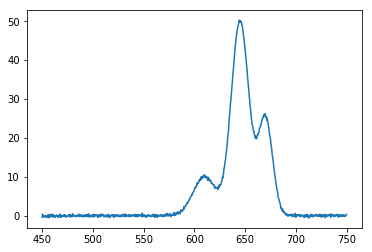

In [12]:
data = np.genfromtxt('spectrum.txt')

plt.plot(data[:,0], data[:,1])
plt.show()

You can see that there are probably 3 peaks in here. What we'd like to find out is what percentage each peak contributes. For example, this would tell us the amount of absorbance contributed by each of these three bonds or perhaps the amount of each compound in chromatography. 

The equation for each peak is:

$$ f(x, a, b, c) = \frac{a}{\sqrt{2 c \pi}}\,e^{-(x - b)^2 / c} $$

and the total spectrum is 

$$ f(x_i, \vec{a}, \vec{b}, \vec{c}) = \sum_j^M \frac{a_j}{\sqrt{2 \pi c_j}} e^{-(x_i - b_j)^2 / c_j} $$

where $j$ is the index of peak and runs from $1$ to $M$ where $M$ is the number of peaks.

Let's start by writing an equation that can predict a spectrum given some parameters

In [13]:
def peak(x, a, b, c):
    '''computes the peak equation for given parameters'''
    return a / np.sqrt(2 * np.pi * c) * np.exp(-(x - b)**2 / c)
def spectrum(x, a_array, b_array, c_array):
    '''Takes in the x data and parameters for a set of peaks. Computes spectrum'''
    yhat = np.zeros(np.shape(x))
    for i in range(len(a_array)):
        yhat += peak(x, a_array[i], b_array[i], c_array[i])
    return yhat
        

It's always good to test your functions, so let's do that

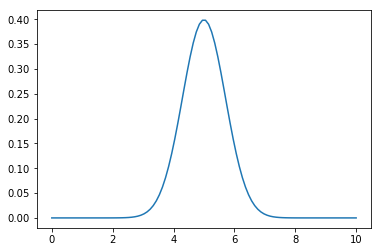

In [14]:
x = np.linspace(0, 10, 100)
y = peak(x, 1, 5, 1)
plt.plot(x,y)
plt.show()

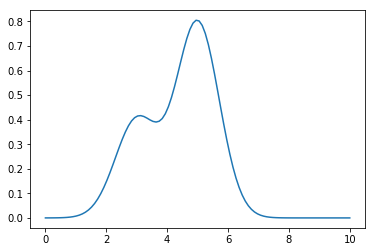

In [15]:
y = spectrum(x, [1, 2], [3, 5], [1,1])
plt.plot(x,y)
plt.show()

Ok! Now let's do the regression

Justifying a regression
---

Let's first test if there is a correlation

In [16]:
spec_x = data[:,0]
spec_y = data[:,1]

scipy.stats.spearmanr(spec_x, spec_y)

SpearmanrResult(correlation=0.34909264909264914, pvalue=4.933615809540912e-30)

Looks like there is a correlation, as indicated by the $p$-value. 

Computing the SSR
---

Let's write our SSR function

In [17]:
def spec_ssr(params, data, M):
    '''Compute SSR given the parameters, data, and number of desired peaks.'''
    x = data[:,0]
    y = data[:,1]
    a_array = params[:M]
    b_array = params[M:2*M]
    c_array = params[2*M:3 * M]
    yhat = spectrum(x, a_array, b_array, c_array)
    return np.sum((yhat - y)**2)

In [18]:
def obj(params):
    return spec_ssr(params, data=data, M=3)

Optimizing
---

Now we need to think aobut if this is non-convex! It is in fact non-convex, because there are many local minimums. This means we'll have to be smart about our starting parameters and/or run for many interations

In [19]:
import scipy.optimize as opt

result = opt.basinhopping(obj, x0=[100, 100, 100, 600, 650, 700, 100, 100, 100], niter=100)
print(result.x)

[ 515.00754662 2001.23149241  179.38225677  644.33899405  651.35194728
  216.63135325   58.43055086  961.08476142  126.84613021]


Let's see if 100 iterations gave us good data!

In [20]:
def spec_yhat(params, data, M):
    '''compute the yhats for the spectrum problem'''
    x = data[:,0]
    a_array = params[:M]
    b_array = params[M:2*M]
    c_array = params[2*M:3 * M]
    return spectrum(x, a_array, b_array, c_array)


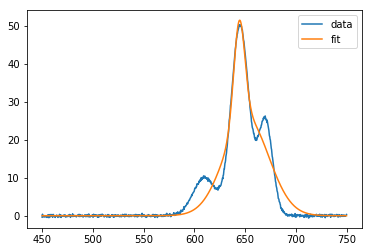

In [21]:
plt.plot(spec_x, spec_y, label='data')
plt.plot(spec_x, spec_yhat(result.x, data, 3), label='fit')
plt.legend()
plt.show()

What a bad fit! Let's try plotting the individual peaks

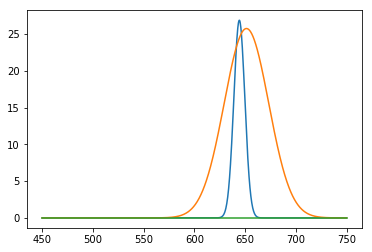

In [22]:
for i in range(3):
    plt.plot(spec_x, peak(spec_x, result.x[i], result.x[i + 3], result.x[i + 6]))

Wow, that is really wrong! We can hit on particular peaks, but they usually have no meaning. Let's try to add more info. What info do we have? The peak centers. Let's try adding some constraints describing this info:

Adding constraints describing what we know:

$$ 600 < b_1 < 630 $$

$$ 630 < b_2 < 650 $$

$$ 650 < b_3 < 690 $$


In [23]:
#constraints follow the order above:

constraints = [{'type': 'ineq', 'fun': lambda params: params[3] - 600},
              {'type': 'ineq', 'fun': lambda params: 630 - params[3]},
              {'type': 'ineq', 'fun': lambda params: params[4] - 630},
              {'type': 'ineq', 'fun': lambda params: 650 - params[4]},
              {'type': 'ineq', 'fun': lambda params: params[5] - 650},
              {'type': 'ineq', 'fun': lambda params: 690 - params[5]}]
minimizer_kwargs = {'constraints': constraints}


In [24]:
result = opt.basinhopping(obj, x0=[100, 100, 100, 600, 650, 700, 100, 100, 100], niter=350, minimizer_kwargs=minimizer_kwargs)
print(result.x)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


[ 396.93605846 1535.87314691  623.85280321  610.00914022  645.00925339
  670.00493358  249.15706481  150.1695907    99.16549081]


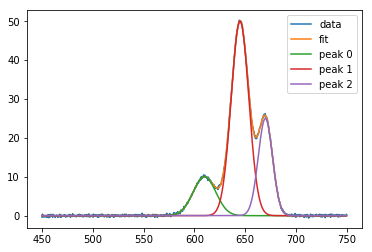

In [25]:
plt.plot(spec_x, spec_y, label='data')
plt.plot(spec_x, spec_yhat(result.x, data, 3), label='fit')
for i in range(3):
    plt.plot(spec_x, peak(spec_x, result.x[i], result.x[i + 3], result.x[i + 6]), label='peak {}'.format(i))
plt.legend()
plt.show()

Checking residuals
---

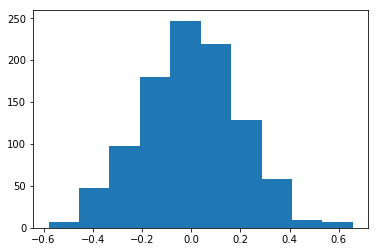

(0.9985383152961731, 0.5798115134239197)

In [26]:
resids = spec_y - spec_yhat(result.x, data, 3)
plt.hist(resids)
plt.show()
scipy.stats.shapiro(resids)

Looks like they are normal

Computing Standard Error
---

We need the partials:

$$\frac{\partial f}{\partial a} = \frac{1}{\sqrt{2 \pi c}}e^{-(x - b)^2 / c}$$

$$\frac{\partial f}{\partial b} = \frac{2a(x - b)}{c\sqrt{2 \pi c}} e^{-(x - b)^2 / c}$$

$$\frac{\partial f}{\partial c} = \frac{a}{\sqrt{2 \pi}}e^{-(x - b)^2 / c}\left[\frac{(x - b)^2}{c^{5/2}} - \frac{1}{2c^{3/2}}\right]$$

In [27]:
def peak_partials(x, a, b, c):
    '''Returns partial derivatives of peak functions with respect to parameters as a tuple'''
    return (1 / (np.sqrt(2 * np.pi * c)) * np.exp(-(x - b)**2 / c), \
            2 * a * (x - b) / c / np.sqrt(2 * np.pi * c) * np.exp(-(x - b)**2 / c),\
            a / np.sqrt( 2 * np.pi) * np.exp(-(x - b)**2 / c) * ((x - b)**2 / c**(5 / 2) - 1 / 2 / c**(3/2)))

We have to decide how we want to build the ${\mathbf F}$ matrix. I want to build it as 

$$\left[\frac{\partial f}{\partial a_1}, \frac{\partial f}{\partial a_2}, \frac{\partial f}{\partial a_3}, \frac{\partial f}{\partial b_1}, \ldots\right]$$

In [28]:
def spectrum_partials(x, a_array, b_array, c_array):
    '''Takes in the x data and parameters for a set of peaks. Computes partial derivatives and returns as matrix'''
    result = np.empty( (len(x), len(a_array) * 3 ) )
    for i in range(len(a_array)):
        a_p, b_p, c_p = peak_partials(x, a_array[i], b_array[i], c_array[i])
        result[:, i] = a_p
        result[:, i  + 3] = b_p
        result[:, i + 6] = c_p
    return result

In [29]:
M = 3
F = spectrum_partials(spec_x, result.x[:M], result.x[M:2*M], result.x[2*M:3*M])
print(F)

[[5.96163850e-047 3.41085036e-112 4.22479807e-214 ... 9.71205239e-045
  8.81670130e-109 1.29594533e-210]
 [8.76433165e-047 7.43573285e-112 1.59991023e-213 ... 1.42240908e-044
  1.91613450e-108 4.89427889e-210]
 [1.28753069e-046 1.61906126e-111 6.04777170e-213 ... 2.08171140e-044
  4.15931841e-108 1.84501215e-209]
 ...
 [3.43347278e-036 9.93866089e-034 9.92393158e-030 ... 4.23817648e-034
  7.32547002e-031 3.93727352e-027]
 [2.45274025e-036 6.54253851e-034 6.12993012e-030 ... 3.04073297e-034
  4.85027389e-031 2.45059976e-027]
 [1.75087494e-036 4.30172947e-034 3.77952653e-030 ... 2.18001288e-034
  3.20751081e-031 1.52246274e-027]]


Now we compute all the confidence intervals

In [30]:
SSR = np.sum(resids**2)
s2_epsilon = SSR / (len(spec_x) - len(result.x))
s2_beta = np.diag(s2_epsilon * linalg.inv(F.transpose() @ F))
ci = np.sqrt(s2_beta) * scipy.stats.norm.ppf(0.975)

for pi, c in zip(result.x, ci):
    print('{} +/- {}'.format(pi, c))

396.9360584626854 +/- 2.9053462007965516
1535.8731469097745 +/- 3.726908748831584
623.8528032145897 +/- 2.9100118852776227
610.0091402212576 +/- 0.09042323859505816
645.0092533938304 +/- 0.018911758759361075
670.0049335827936 +/- 0.03502566911286785
249.1570648134466 +/- 4.418077471259899
150.16959069781274 +/- 0.845817735826172
99.16549080652315 +/- 0.9623322371153976


The relative populations, the integrated peaks, are just the $a$ values. I'll normalize them into percent:

In [31]:
for pi, c in zip(result.x[:3], ci[:3]):
    print('{:%} +/- {:%}'.format(pi / np.sum(result.x[:3]), c / np.sum(result.x[:3])))

15.525559% +/- 0.113638%
60.073375% +/- 0.145772%
24.401067% +/- 0.113821%
